# Ocenjevanje in izbor značilk

V angleščini je postopek [ocenjevanja in izbora](https://en.wikipedia.org/wiki/Feature_selection) najbolj informativnih značilk znan pod imenom *feature subset selection*, če o postopku govorijo tisti, ki jim je blizu strojno učenje, ali pa *shrinkage*, če si statistik.

In [1]:
import Orange
import numpy as np
import scipy
from matplotlib import pyplot as plt
from Orange.preprocess.preprocess import Preprocess
import random
%matplotlib inline

## Podatki

In [2]:
orig = Orange.data.Table("digits-sample.csv")
# orig = Orange.data.Table("seven-nine.csv")
orig = Orange.data.Table("smoking-small")  # GDS3713

In [3]:
len(orig.domain.attributes)

1000

In [4]:
orig.domain.class_var

DiscreteVariable('stress', values=['cigarette smoke', 'control'])

## Odstranjevanje atributov s konstantnimi vrednostmi

Orange uporablja predprocesorje, to je objekte, ki prejmejo podatke, nekaj z njimi naredijo, in potem to vrnejo. Predprocesorje lahko uporabljamo direktno, na podatkih samih, ali pa jih lahko na primer podtaknemo razredom za učenje, ki predprocesorje uporabijo na prejeti učni množici primerov.

In [5]:
class RemoveConstant(Preprocess):
    def __call__(self, data):
        oks = np.min(data.X, axis=0) != np.max(data.X, axis=0)
        atts = [a for a, ok in zip(data.domain.attributes, oks) if ok]
        domain = Orange.data.Domain(atts, data.domain.class_vars)
        return Orange.data.Table(domain, data)

In [6]:
rc = RemoveConstant()
data = rc(orig)
len(data.domain.attributes)

1000

## Ocenjevanje atributov in permutacijski test

Spodaj "ročno" ocenimo informativnost atributov in pri tem uporabimo t statistiko. Primerjamo ocene te statistike na učni množici primerov in na primerih, kjer smo razred naključno premešali, oziroma permutirali. 

In [7]:
X = data.X
y = data.Y
t, p = scipy.stats.ttest_ind(X[y == 0], X[y == 1], axis=0)
scores = np.abs(t)

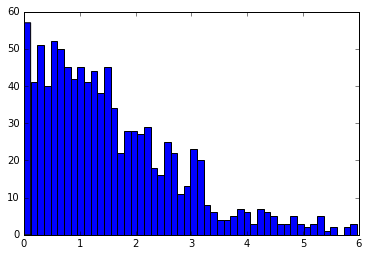

In [8]:
plt.hist(scores, 50);

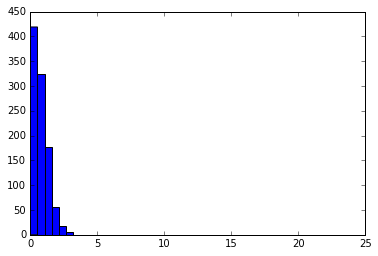

In [9]:
y = np.copy(data.Y)
np.random.shuffle(y)
t, p = scipy.stats.ttest_ind(X[y == 0], X[y == 1], axis=0)
plt.hist(np.abs(t), 6)
plt.xlim(0, 25);

In [10]:
null = np.array([])
for i in range(5):
    np.random.shuffle(y)
    null = np.hstack((null, 
                      np.abs(scipy.stats.ttest_ind(X[y == 0],
                                                   X[y == 1],
                                                   axis=0)[0])))

Spodaj na istem grafu primerjamo porazdelitev ocen atributov na pravih podatkih in te, ki smo jih dobili na podatki s permutiranim vektorjem razredov (t.im. ničelna porazdelitev). V ničelni porazdelitvi označimo točko praga oziroma točko, od katere desno je samo *alpha* meritev, kjer je *alpha* nek ročno določen delež.

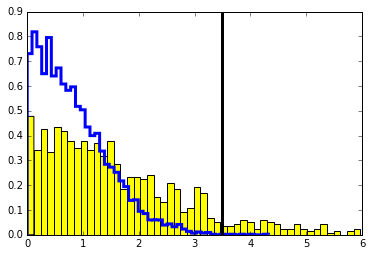

In [11]:
plt.hist(scores, 50, color="yellow", normed=True)
plt.hist(null, 50, color="blue", normed=True, histtype='step', lw=3)
alpha = 0.001
threshold = np.sort(null)[int((1-alpha)*len(null))]
plt.vlines(threshold, plt.ylim()[0], plt.ylim()[1], lw=3, color="k");

In [12]:
threshold

3.482648286657744

## Predprocesor za izbor najboljših atributov

Zgradimo predprocesor, ki oceni atribute in vrne podatke, ki med atributi vključujejo samo nekaj (*n*) najboljših. Za primerjavo zgradimo tudi predprocesor, ki vrne podatke z *n* naključno izbranimi atributi.

In [13]:
class SelectBest(Preprocess):
    def __init__(self,
                 n=10,
                 measure=lambda X, y: np.abs(scipy.stats.ttest_ind(X[y == 0],
                                                                   X[y == 1],
                                                                   axis=0)[0])
                 ):
        self.n = n
        self.measure = measure

    def __call__(self, data):
        scores = self.measure(data.X, data.Y)
        ind = set(list(zip(*sorted(zip(scores, range(len(
            data.domain.attributes))), reverse=True)[:self.n]))[1])
        att = [a for i, a in enumerate(data.domain.attributes) if i in ind]
        domain = Orange.data.Domain(att, data.domain.class_vars)
        return Orange.data.Table(domain, data)
    
class SelectRandom(Preprocess):
    def __init__(self, n=10):
        self.n = n

    def __call__(self, data):
        att = random.sample(data.domain.attributes, min(n, len(data)))
        domain = Orange.data.Domain(att, data.domain.class_vars)
        return Orange.data.Table(domain, data)

Oba predprocesorja tu uporabimo. In sicer nas zanima, ali se napovedna točnost metode k-najbližjih sosedov spremeni ali celo izboljša. Za naključni izbor značilk seveda pričakujemo poslabšanje napovedne točnosti.

In [14]:
n = 50
sb = SelectBest(n=n)
sr = SelectRandom(n=n)

In [15]:
knn = Orange.classification.KNNLearner(preprocessors=[rc])
knn_pp = Orange.classification.KNNLearner(preprocessors=[rc, sb])
knn_rnd = Orange.classification.KNNLearner(preprocessors=[rc, sr])

In [16]:
res = Orange.evaluation.CrossValidation(data, [knn, knn_pp, knn_rnd])
Orange.evaluation.AUC(res)

array([ 0.725     ,  0.85833333,  0.55      ])

## Preprocessor za izbor značilno informativnih atributov

Za značilno informativne atribute velja, da je njihova ocena "boljša" od te, ki bi jo lahko dobili na podatkih s permutiranim razredom. Tu, konkretno, poiščemo prag za take ocene. Na permutiranih podatkih ocenimi atribute in prag določimo tako, da je samo en manjši delež (*alpha*) teh ocen večji od tega praga.

In [17]:
class SelectByPermutationTest(Preprocess):
    def __init__(self,
                 alpha=0.01,
                 measure=lambda X, y: np.abs(scipy.stats.ttest_ind(X[y == 0],
                                                                   X[y == 1],
                                                                   axis=0)[0]),
                 n_permutations=1):
        self.p = alpha
        self.measure = measure
        self.n_permutations = n_permutations

    def __call__(self, data):
        y = np.copy(data.Y)
        X = data.X

        null = np.array([])
        for i in range(self.n_permutations):
            np.random.shuffle(y)
            null = np.hstack((null, self.measure(X, y)))

        ss = np.sort(null)
        index = int((1-self.p)*len(null))
        threshold = ss[index]

        scores = self.measure(X, data.Y)
        att = [a for score, a in zip(scores, data.domain.attributes)
               if score > threshold]
        print("Attributes", len(att))
        domain = Orange.data.Domain(att, data.domain.class_vars)
        return Orange.data.Table(domain, data)

Zadevo ponovno preverimo v povezavi z metodo najbližjih sosedov. Tokrat število izbranih atributov ne bo konstantno, ampak raje odvisno od vsakokratne sestave množice učnih primerov v iteraciji prečnega preverjanja.

In [18]:
spt = SelectByPermutationTest(alpha=0.001)
knn_spt = Orange.classification.KNNLearner(preprocessors=[rc, spt])

In [19]:
res = Orange.evaluation.CrossValidation(data, [knn, knn_spt])
Orange.evaluation.AUC(res)

Attributes 143
Attributes 71
Attributes 114
Attributes 62
Attributes 101
Attributes 44
Attributes 56
Attributes 85
Attributes 135
Attributes 71


array([ 0.725     ,  0.85833333])

## Interpretacija rezultatov

Način interpretacije za problem z razvrščanjem cifr se ponuja kar sam po sebi: izrišemo ocene za pomembnost značilk tako, kot bi izrisale same cifre  v podatki. Za poskus sicer najprej izrišimo kakšen primer v podatkih, potem pa ta isti postopek uporabimo za izris vrednosti ocen atributov. Nalov "interpretacija rezultatov" je tu sicer napačen. S takim izrisom namreč šele omogočimo interpretacijo. 

In [20]:
orig = Orange.data.Table("digits-sample.csv")

import itertools
c = np.array(list(range(28))*28)
r = np.array(list(itertools.chain(*[[27-i]*28 for i in range(28)])))

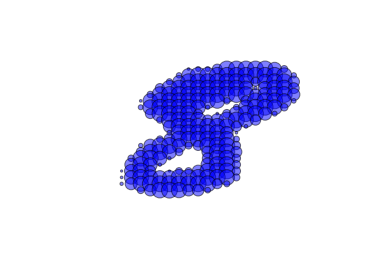

In [21]:
ex = orig[2]
plt.scatter(c, r, marker="o", s=list(ex), alpha=0.5)
plt.axis("off");

In [22]:
X = orig.X
y = orig.Y
t, p = scipy.stats.ttest_ind(X[y == 0], X[y == 1], axis=0)
scores = np.abs(t)

/Users/blaz/.virtualenvs/orange/lib/python3.5/site-packages/scipy/stats/stats.py:3388: RuntimeWarning: invalid value encountered in true_divide
  t = np.divide(d, denom)
/Users/blaz/.virtualenvs/orange/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1757: RuntimeWarning: invalid value encountered in greater
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
/Users/blaz/.virtualenvs/orange/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1757: RuntimeWarning: invalid value encountered in less
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
/Users/blaz/.virtualenvs/orange/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1758: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


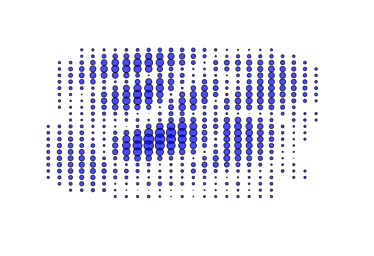

In [23]:
plt.scatter(c, r, marker="o", s=scores*5, alpha=0.7)
plt.axis("off");